Many normalization techniques follow the same recipe, which involves subtracting a mean statistics from the input, dividing the result by a standard deviation statistics, and finally rescaling and shifting the output with learnable parameters:

\\[ y = \frac{x - \mathbb{E}[x]}{\sqrt{\text{Var}[x] + \epsilon}} * \gamma + \beta.\\]

The differences between these techniques mostly lie in how the mean and standard deviation are computed. Suppose we have a minibatch of inputs of size $N \times C \times H \times W$.

* Batch normalization [(Ioffe and Szegedy, 2015)](https://arxiv.org/abs/1502.03167) normalizes across both the batch axis ($N$) and spatial axes ($H, W$).
* Instance normalization [(Ulyanov et al., 2016)](https://arxiv.org/abs/1607.08022) normalizes across the spatial axes only ($H, W$).
* Layer normalization [(Ba et al., 2016)](https://arxiv.org/abs/1607.06450) normalizes across the channel axis ($C$) and spatial axes ($H, W$).
* Group normalization [(Wu and He, 2018)](https://arxiv.org/abs/1803.08494) normalizes across the grouped channel axis ($C$) and spatial axes ($H, W$).

<img src="images/normalization/normalization-methods.png" width=60%>
<center> Figure 1: Normalization methods. The pixels in blue are normalized by the same mean and variance, computed by aggregating the values of these pixels (Wu and He, 2018). </center>

### Batch Normalization

Batch normalization [(Ioffe and Szegedy, 2015)](https://arxiv.org/abs/1502.03167) is the one that started it all. Besides the batch axis, the authors deliberately take average of activations over the spatial axes, arguing that to be consistent with the translation invariance of convolutional layers, the activations across the spatial locations should be normalized the same way. Hence, a minibatch of size $N \times C \times H \times W$ yields $C$-dimensional mean and variance vectors, i.e. each channel has a scalar mean and variance. The learnable scale parameters $\gamma$ and shift parameters $\beta$ are also $C$-dimensional.

The original paper motivates batch norm as a way to work around the "internal covariate shift". As the weights of a particular layer change during training, the input distributions of subsequent layers are forced to change continuously, making it harder to optimize the weights of these layers. The argument makes sense, but it's somewhat irrelevant to batch norm because besides standardization, the method introduces learnable parameters to explicitly change the input distributions during training as well.

Recently, [Santurkar et al. (2019)](Santurkar) claim that the success of batch norm has nothing to do with the internal covariate shift! The authors don't really see any noticeable changes in the distributions of activations without batch norm, and even when introduced, the changes barely affect the performance. Instead, the authors think that batch norm actually makes the optimization problem easier by bounding the magnitude of the gradients, improving the $\beta$-smoothness of the loss function.

Although it's still not clear why batch norm works, its effectiveness is beyond any doubt. The benefits include (1) training speedup due to higher learning rate, (2) less sensitivity to initialization, and (3) implicit regularization to fight against overfitting. The last consequence can be explained by the extra noise added to the gradients by batch norm; the mean and standard deviation statistics make an instance dependent on every other ones in the same batch.

The following code shows that our implementation of batch norm agrees with the one provided by PyTorch. Running mean and variance are calculated during training so they can later be used during validation.

In [76]:
import torch
import torch.nn as nn

class BatchNorm2d(nn.Module):
    def __init__(self, num_features, epsilon=1e-5, momentum=0.1):
        super().__init__()
        self.momentum = momentum
        self.epsilon = epsilon
        self.weight = nn.Parameter(torch.Tensor(num_features).uniform_())
        self.bias = nn.Parameter(torch.Tensor(num_features).zero_())
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        
    def forward(self, input):
        N, C, H, W = input.size()
        flatten = input.permute(0, 2, 3, 1).contiguous().view(N * H * W, C)
            
        if self.training:
            batch_mean = flatten.mean(dim=0)
            # The PyTorch implementation uses n degrees of freedom for variance instead of n - 1
            batch_var = flatten.var(dim=0) * (flatten.size(0) - 1) / flatten.size(0)
            self.running_mean = self.momentum * batch_mean + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * batch_var + (1 - self.momentum) * self.running_var
        
        mean = batch_mean if self.training else self.running_mean
        var = batch_var if self.training else self.running_var
        output = (flatten - mean) / (var + self.epsilon).sqrt() * self.weight + self.bias
        return output.view(N, H, W, C).permute(0, 3, 1, 2)
    

batch_norm = BatchNorm2d(100)
bn_torch = nn.BatchNorm2d(100)
bn_torch.weight = batch_norm.weight
bn_torch.bias = batch_norm.bias

for i in range(100):
    batch_norm.training = bn_torch.training = (i > 50)
    input = torch.randn(20, 100, 3, 5)
    assert torch.allclose(batch_norm(input), bn_torch(input), atol=1e-7)

### Instance Normalization

Instance normalization [(Ulyanov et al., 2016)](https://arxiv.org/abs/1607.08022) is very similar to batch normalization. The only difference is that we don't normalize across the batch axis, i.e. each minibatch of size $N \times C \times H \times W$ has $N \times C$ separate means and standard deviations. The running mean and variance are still computed with all instances in the minibatch, though. Practically, instance normalization has worked well on style transfer, although it's arguably less popular than the other normalization techniques.

In [291]:
import torch
import torch.nn as nn

class InstanceNorm2d(nn.Module):
    def __init__(self, num_features, epsilon=1e-5, momentum=0.1):
        super().__init__()
        self.momentum = momentum
        self.epsilon = epsilon
        self.weight = nn.Parameter(torch.Tensor(num_features).uniform_())
        self.bias = nn.Parameter(torch.Tensor(num_features).zero_())
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        
    def forward(self, input):
        N, C, H, W = input.size()
        flatten = input.view(N, C, H * W)
            
        if self.training:
            batch_mean = flatten.mean(dim=-1, keepdim=True)
            # The PyTorch implementation uses n degrees of freedom for variance instead of n - 1
            batch_var = flatten.var(dim=-1, keepdim=True) * (flatten.size(-1) - 1) / flatten.size(-1)
            self.running_mean = self.momentum * batch_mean.mean(0).squeeze() + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * batch_var.mean(0).squeeze() + (1 - self.momentum) * self.running_var
        
        mean = batch_mean if self.training else self.running_mean.unsqueeze(0).repeat(N, 1)
        var = batch_var if self.training else self.running_var.unsqueeze(0).repeat(N, 1)
        output = ((flatten - mean) / (var + self.epsilon).sqrt()).view_as(input)
        output = output * self.weight.view(1, -1, 1, 1) + self.bias.view(1, -1, 1, 1)
        return output

instance_norm = InstanceNorm2d(100)
in_torch = nn.InstanceNorm2d(100, affine=True)
in_torch.weight = instance_norm.weight
in_torch.bias = instance_norm.bias

for _ in range(100):
    input = torch.randn(20, 100, 35, 45)
    assert torch.allclose(instance_norm(input), in_torch(input), atol=1e-7)

### Layer Normalization

There are two main disadvantages of batch norm that layer normalization can help. First, when the batch size $N$ is small (sometimes $N = 1$ due to limited GPU memory), the mean and variance estimates are very noisy. Second, it's not clear how to apply batch norm to recurrent neural networks where the number of channels $C$ depends on the lengths of input sequences.

Layer normalization [(Ba et al., 2016)](https://arxiv.org/abs/1607.06450) typically computes the mean and variance statistics using all channels of the channeled inputs like images. For a minibatch of size $N \times C \times H \times W$, the mean and variance vectors are $N$-dimensional, and the learnable scaling and shifting parameters are of size $C \times H \times W$. The following implementation follows the same API as the official PyTorch implementation, where we also allow the mean and standard deviation to be calculated over the last certain number dimensions, such as  $C \times H \times W$, $H \times W$, or $W$. Note that if we use the last two dimensions, layer normalization and instance normalization have the same statistics for the moments, but the former has parameters for spatial locations whereas the latter has parameters for channels.

Layer normalization doesn't work with convolutional neural networks as well as batch normalization. 

In [78]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon
        self.normalized_shape = torch.Size(normalized_shape)
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        
    def forward(self, input):
        keep_dims = input.size()[:-len(self.normalized_shape)]
        flatten = input.view(*keep_dims, -1)
        shape = list(keep_dims) + [1] * (len(self.normalized_shape))

        mean = flatten.mean(dim=-1).view(*shape)
        # The PyTorch implementation uses n degrees of freedom for variance instead of n - 1
        var = flatten.var(dim=-1).view(*shape) * (flatten.size(-1) - 1) / flatten.size(-1)
        output = (input - mean) / (var + self.epsilon).sqrt() * self.weight + self.bias
        return output

layer_norm = LayerNorm(normalized_shape=[35, 45])
ln_torch = nn.LayerNorm(normalized_shape=[35, 45])
ln_torch.weight = layer_norm.weight
ln_torch.bias = layer_norm.bias

for _ in range(100):
    input = torch.randn(20, 100, 35, 45)
    assert torch.allclose(layer_norm(input), ln_torch(input), atol=1e-7)

### Group Normalization

Similar to instance normalization and layer normalization, group normalization [(Wu and He, 2018)](https://arxiv.org/abs/1803.08494) avoids averaging over the batch dimension. The idea is that all channels in channeled inputs are perhaps not homogeneous and thus should be normalized somewhat differently. As suggested by its name,  group norm divides $C$ channels into $G$ groups, each of size $C / G$, and the means and standard deviations are calculated separately over the each group. When $G$ varies between $1$ and $C$, we see resemblances of instance normalization and layer normalization, respectively.

In [263]:
import torch
import torch.nn as nn

class GroupNorm(nn.Module):
    def __init__(self, num_groups, num_channels, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon
        self.num_groups = num_groups
        self.num_channels = num_channels
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        
    def forward(self, input):
        # N x C x H x W -> N x G x ((C / G) x H x W)
        flatten = input.view(input.size(0), self.num_groups, -1)
        mean = flatten.mean(dim=-1, keepdim=True)
        # The PyTorch implementation uses n degrees of freedom for variance instead of n - 1
        var = flatten.var(dim=-1, keepdim=True) * (flatten.size(-1) - 1) / flatten.size(-1)
        output = ((flatten - mean) / (var + self.epsilon).sqrt()).view_as(input)
        output = output * self.weight.view(1, -1, 1, 1) + self.bias.view(1, -1, 1, 1)
        return output

group_norm = GroupNorm(num_groups=5, num_channels=100)
gn_torch = nn.GroupNorm(num_groups=5, num_channels=100)
gn_torch.weight = group_norm.weight
gn_torch.bias = group_norm.bias

for _ in range(100):
    input = torch.randn(20, 100, 35, 45)
    assert torch.allclose(group_norm(input), gn_torch(input), atol=1e-7)

### Experiments on CIFAR10

Ideally, we should compare the normalization methods using the same learning schedule as done in [Wu and He (2018)](https://arxiv.org/abs/1803.08494). However, most of these methods don't work with high learning rate such as 0.1 (the loss explodes initially and quickly drops down to 2.302 but then stops decreasing afterward). Batch norm amazingly works with learning rate as high as 0.5, although it doesn't result in its best performance. Since we're still interested in minimizing training time, we set the learning rate as high as possible for each method separately.

For all normalization techniques, the learnable parameters for scaling are set to 1 initially, and those for shifting are set to 0. Instance normalization typically doesn't come with learnable parameters, but it seems including them improve its performance a bit.

In [46]:
import logging
import math
import numpy as np
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import namedtuple
from tqdm import tqdm_notebook as tqdm
from torchvision import datasets, transforms


class VGG16(nn.Module):
    def __init__(self, num_classes=10, batch_norm=False, instance_norm=False, layer_norm=False, group_norm=False):
        super().__init__()
        assert sum([batch_norm, instance_norm, layer_norm, group_norm]) <= 1
        layers, in_channels = [], 3
        for i, (num_layers, num_channels) in enumerate([(2, 64), (2, 128), (3, 256), (3, 512), (3, 512)]):
            for _ in range(num_layers):
                layers.append(nn.Conv2d(in_channels, num_channels, 3, padding=1))
                layers.append(nn.BatchNorm2d(num_channels)) if batch_norm else None
                layers.append(nn.InstanceNorm2d(num_channels, affine=True)) if instance_norm else None
                layers.append(nn.LayerNorm([num_channels, 32 // 2 ** i, 32 // 2 ** i], elementwise_affine=True)) if layer_norm else None
                layers.append(nn.GroupNorm(64, num_channels)) if group_norm else None
                layers.append(nn.ReLU(True))
                in_channels = num_channels
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Linear(512, num_classes)
        self.initialize_weights()
        
    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                n = module.kernel_size[0] * module.kernel_size[1] * module.out_channels
                module.weight.data.normal_(0, math.sqrt(2. / n))
                module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()
            elif isinstance(module, nn.Linear):
                module.weight.data.normal_(0, 0.01)
                module.bias.data.zero_()
                
    def forward(self, input):
        output = self.features(input).view(input.size(0), -1)
        output = self.classifier(output)
        return output

def train(args):
    # Reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    logging.basicConfig(stream=sys.stdout, format='[%(asctime)s] %(message)s', datefmt='%Y-%m-%d %H:%M:%S', level=logging.INFO)
    
    # Load datasets
    train_loader, valid_loader = load_cifar10(args)
    logging.info('Loaded a train dataset of {} images'.format(len(train_loader.dataset)))
    logging.info('Loaded a validation dataset of {} images'.format(len(valid_loader.dataset)))
    
    # Build a model
    model = VGG16(args.num_classes, args.batch_norm, args.instance_norm, args.layer_norm, args.group_norm).cuda()
    logging.info('Built a model consisting of {:,} parameters with {} normalization'.format(
        sum(p.numel() for p in model.parameters()), 'batch' if args.batch_norm else 'instance' if args.instance_norm
            else 'layer' if args.layer_norm else 'group' if args.group_norm else 'no'))
    
    # Build an optimizer
    optimizer = torch.optim.SGD(model.parameters(), args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=args.lr_shrink)
    train_stats, valid_stats, best_score = [], [], 0
    
    for epoch in range(args.max_epoch):
        model.train()
        lr_scheduler.step()
        train_loss, train_accuracy, count = 0., 0., 0
        progress_bar = tqdm(train_loader, desc='| Epoch {:03d}'.format(epoch), leave=False)
        
        for batch_id, sample in enumerate(progress_bar):
            input, target = sample[0].cuda(), sample[1].cuda()
            output = model(input)
            loss = F.cross_entropy(output, target)
            pred = output.max(1, keepdim=True)[1]
            accuracy = 100 * pred.eq(target.view_as(pred)).sum().float() / len(input)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            count += len(input)
            train_loss += len(input) * loss.item()
            train_accuracy += len(input) * accuracy.item()
            stats = {'loss': train_loss / count, 'accuracy': train_accuracy / count, 'lr': optimizer.param_groups[0]['lr']}
            progress_bar.set_postfix({key: '{:.4g}'.format(value) for key, value in stats.items()}, refresh=True)
        
        train_loss, train_accuracy = train_loss / count, train_accuracy / count
        train_stats.append((train_loss, train_accuracy))

        valid_loss, valid_accuracy = validate(args, model, valid_loader, epoch)
        valid_stats.append((valid_loss, valid_accuracy))
        best_score = max(best_score, valid_accuracy)
        if epoch % 10 == 0:
            logging.info('Epoch {:03d}: train_loss {:.3f} | train_accuracy {:.3f} | valid_loss {:.3f} | valid_accuracy {:.3f} | lr {:.4g}'.format(
                epoch, train_loss, train_accuracy, valid_loss, valid_accuracy, optimizer.param_groups[0]['lr']))
        
    logging.info('Done training! Best validation accuracy {}.'.format(best_score))
    return train_stats, valid_stats
            
            
def validate(args, model, valid_loader, epoch):
    model.eval()
    valid_loss, valid_accuracy, count = 0., 0., 0
    progress_bar = tqdm(valid_loader, desc='| Epoch {:03d}'.format(epoch), leave=False)

    for batch_id, sample in enumerate(progress_bar):
        input, target = sample[0].cuda(), sample[1].cuda()
        output = model(input)
        loss = F.cross_entropy(output, target)
        pred = output.max(1, keepdim=True)[1]
        accuracy = 100 * pred.eq(target.view_as(pred)).sum().float() / len(input)

        count += len(input)
        valid_loss += len(input) * loss.item()
        valid_accuracy += len(input) * accuracy.item()
        stats = {'valid_loss': valid_loss / count, 'valid_accuracy': valid_accuracy / count}
        progress_bar.set_postfix({key: '{:.4g}'.format(value) for key, value in stats.items()}, refresh=True)

    valid_loss, valid_accuracy = valid_loss / count, valid_accuracy / count
    return valid_loss, valid_accuracy

    
def load_cifar10(args):
    # Load train dataset
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root=args.data, download=not os.path.exists(args.data), train=True, transform=train_transform),
        shuffle=True, batch_size=args.batch_size, num_workers=args.num_workers,
    )

    # Load validation dataset
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    valid_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root=args.data, download=not os.path.exists(args.data), train=False, transform=valid_transform),
        shuffle=False, batch_size=args.batch_size, num_workers=args.num_workers,
    )
    return train_loader, valid_loader


base_args = {
    'seed': 42, 'data': '/tmp/cifar10', 'num_classes': 10, 'batch_size': 100, 'num_workers': 1,
    'max_epoch': 100, 'lr': 0.09, 'momentum': 0.9, 'weight_decay': 5e-4, 'lr_shrink': 0.1,
    'batch_norm': False, 'instance_norm': False, 'layer_norm': False, 'group_norm': False,
}

# Train VGG16 without normalization
std_args = namedtuple('Arguments', base_args.keys())(*base_args.values())
std_train_stats, std_valid_stats = train(std_args)

# Train VGG16 with batch norm
bn_args = dict(base_args, batch_norm=True, lr=0.1)
bn_args = namedtuple('Arguments', bn_args.keys())(*bn_args.values())
bn_train_stats, bn_valid_stats = train(bn_args)

# Train VGG16 with instance norm
in_args = dict(base_args, instance_norm=True, lr=0.04)
in_args = namedtuple('Arguments', in_args.keys())(*in_args.values())
in_train_stats, in_valid_stats = train(in_args)

# Train VGG16 with layer norm
ln_args = dict(base_args, layer_norm=True, lr=0.02)
ln_args = namedtuple('Arguments', ln_args.keys())(*ln_args.values())
ln_train_stats, ln_valid_stats = train(ln_args)

# Train VGG16 with group norm
gn_args = dict(base_args, group_norm=True, lr=0.02)
gn_args = namedtuple('Arguments', gn_args.keys())(*gn_args.values())
gn_train_stats, gn_valid_stats = train(gn_args)

[2019-04-09 10:46:41] Loaded a train dataset of 50000 images
[2019-04-09 10:46:41] Loaded a validation dataset of 10000 images
[2019-04-09 10:46:42] Built a model consisting of 14,719,818 parameters with no normalization
[2019-04-09 10:47:00] Epoch 000: train_loss 2.133 | train_accuracy 17.566 | valid_loss 1.912 | valid_accuracy 24.930 | lr 0.09
[2019-04-09 10:50:06] Epoch 010: train_loss 0.935 | train_accuracy 69.708 | valid_loss 0.848 | valid_accuracy 72.610 | lr 0.09
[2019-04-09 10:53:13] Epoch 020: train_loss 0.733 | train_accuracy 76.672 | valid_loss 0.738 | valid_accuracy 75.880 | lr 0.09
[2019-04-09 10:56:19] Epoch 030: train_loss 0.417 | train_accuracy 86.464 | valid_loss 0.421 | valid_accuracy 86.170 | lr 0.009
[2019-04-09 10:59:24] Epoch 040: train_loss 0.194 | train_accuracy 93.526 | valid_loss 0.313 | valid_accuracy 89.790 | lr 0.009
[2019-04-09 11:02:33] Epoch 050: train_loss 0.136 | train_accuracy 95.322 | valid_loss 0.332 | valid_accuracy 89.980 | lr 0.009
[2019-04-09 11

It's surprising that without any form of normalization, the VGG16 network still performs rather well, even with high learning rate. However, the performance greatly depends on proper initialization, because without it, the SGD doesn't work with any learning rate at all, even with one as small as 1e-4. Initialization for convolutional layers seem more important than linear layers, and Kaiming He's initialization is best. In contrast, batch norm is more robust with initialization; even random normal initialization for convolutional weights is good enough.

All of the normalization techniques seem to speed up the training, as we see that the loss decreases significantly slower without them. These methods perform quite similarly on CIFAR10, although the experiment on ImageNet [(Wu and He, 2018)](https://arxiv.org/abs/1803.08494) show that batch norm and group norm stand out more clearly. Despite the discrepancies, given large enough batch size, batch norm is still the best among these methods at the end of the training. Interestingly, the validation loss and accuracy curves are quite bumpy for batch norm on this small dataset, perhaps due to the inhomogeneity of training and testing images as well as additional preprocessing steps such as random cropping.

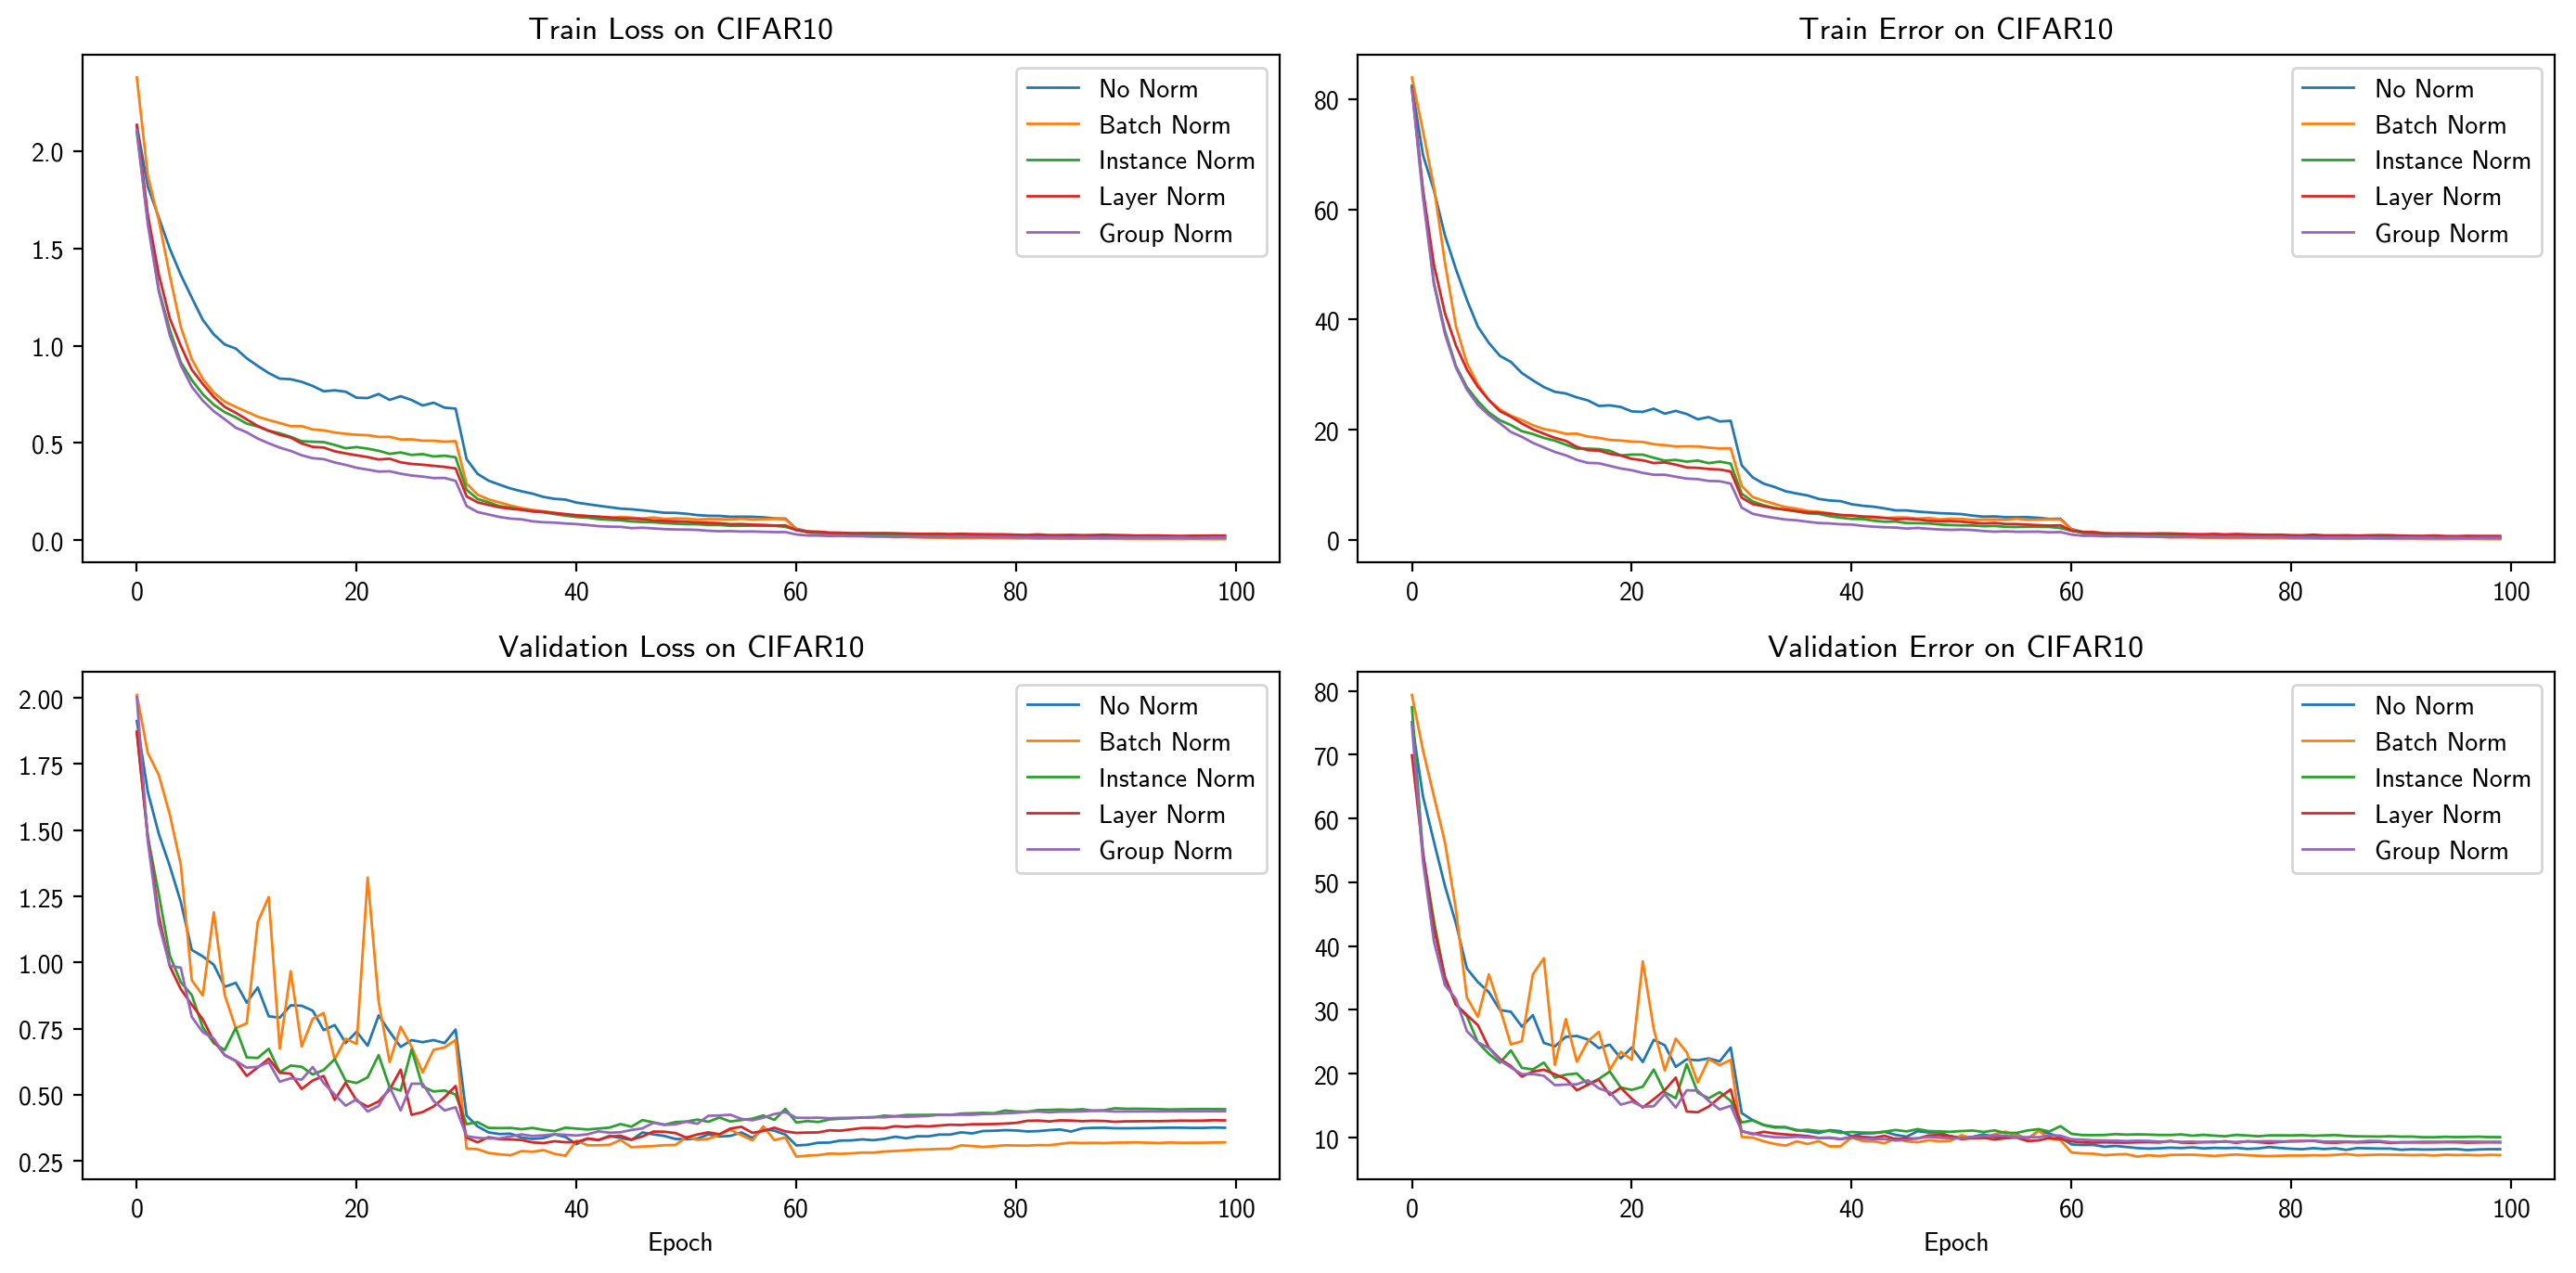

In [79]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.dpi'] = 100
train_loss, train_accuracy, valid_loss, valid_accuracy = {}, {}, {}, {}
for name, train_stats in [('no', std_train_stats), ('batch', bn_train_stats), ('instance', in_train_stats), ('layer', ln_train_stats), ('group', gn_train_stats)]:
    train_loss[name], train_accuracy[name] = zip(*train_stats)
for name, valid_stats in [('no', std_valid_stats), ('batch', bn_valid_stats), ('instance', in_valid_stats), ('layer', ln_valid_stats), ('group', gn_valid_stats)]:
    valid_loss[name], valid_accuracy[name] = zip(*valid_stats)
    
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
for name, series in train_loss.items():
    axes[0][0].plot(range(len(series)), series, linewidth=1, label='{} Norm'.format(name.capitalize()))
axes[0][0].set_title('Train Loss on CIFAR10')

for name, series in train_accuracy.items():
    axes[0][1].plot(range(len(series)), 100 - np.array(series), linewidth=1, label='{} Norm'.format(name.capitalize()))
axes[0][1].set_title('Train Error on CIFAR10')

for name, series in valid_loss.items():
    axes[1][0].plot(range(len(series)), series, linewidth=1, label='{} Norm'.format(name.capitalize()))
axes[1][0].set_title('Validation Loss on CIFAR10')

for name, series in valid_accuracy.items():
    axes[1][1].plot(range(len(series)), 100 - np.array(series), linewidth=1, label='{} Norm'.format(name.capitalize()))
axes[1][1].set_title('Validation Error on CIFAR10')

for i, (ax0, ax1) in enumerate(axes):
    ax0.legend(); ax1.legend()
    if i == 1:
        ax0.set_xlabel('Epoch'); ax1.set_xlabel('Epoch');
plt.tight_layout()

In [2]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())